In [1]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.6 MB/s eta 0:00:00


Upload files:

In [12]:
import pandas as pd
from IPython.display import display
import os
import matplotlib.pyplot as plt
import math
import numpy as np
from nltk.tokenize import sent_tokenize
import string
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, RepeatedKFold, learning_curve
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Lasso, RidgeClassifier, RidgeClassifierCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score, hamming_loss, mean_squared_error, log_loss

encoder=OneHotEncoder()

class DataFrameSelector(BaseEstimator):
    
    def __init__(self, attribute_names):
        self.attribute_names= attribute_names
        
    def fit(self,X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values


local_path = '/content/'

# files = ['bahai', 'buddhism', 'christianity', 'hinduism', 'historical', 'islam','judaism', 'p_j_s', 'shinto', 't_c', 'iranian']
files = ['buddhism', 'christianity', 'hinduism', 'islam','judaism', 'p_j_s', 'shinto', 't_c']
additions = ['BU', 'CH', 'AS',  'IS', 'JU', 'AS', 'EA', 'EA']
frames = [0]*8
results = [0]*8

def addColumn(files, additions, frames):
    for i in range(len(files)):
        csv_path=os.path.join(local_path, files[i] + '.csv')
        df = pd.read_csv(csv_path, nrows=4500) 
        df2 = df.assign(Religion=additions[i])
        frames[i] = df2

# # combine dataframes to one
addColumn(files, additions, frames)
combined_df = pd.concat(frames, ignore_index=True)
combined_df = combined_df.rename(columns={"Language of Original Document": "Language"})
combined_df = combined_df.rename(columns={"Funding Details": "Funding"})
combined_df = combined_df.rename(columns={"Cited by": "Cited"})

display(combined_df)

,Year,Cited,Link,Affiliations,Funding,Language,Religion
0,2019,0,https://www.scopus.com/inward/record.uri?eid=2...,"Department of Religious Studies, Faculty of Le...","Japan Society for the Promotion of Science, JS...",English,BU
1,2017,0,https://www.scopus.com/inward/record.uri?eid=2...,"Department of Sociology, University of Peraden...",NaN,English,BU
2,2023,0,https://www.scopus.com/inward/record.uri?eid=2...,"College of Liberal Arts, Temple University, Ph...",NaN,English,BU
3,2021,0,https://www.scopus.com/inward/record.uri?eid=2...,"University of Chicago, Chicago, IL, United States",NaN,English,BU
4,2011,10,https://www.scopus.com/inward/record.uri?eid=2...,"Canterbury Christ Church University, United Ki...",NaN,English,BU
...,...,...,...,...,...,...,...
28156,2004,52,https://www.scopus.com/inward/record.uri?eid=2...,"College of Nursing, Keimyung University, Daegu...","National Institute of Nursing Research, NINR, ...",English,EA
28157,2023,0,https://www.scopus.com/inward/record.uri?eid=2...,"Ghent University, Ghent, Belgium",NaN,English,EA
28158,2021,0,https://www.scopus.com/inward/record.uri?eid=2...,"College of Business, Shanghai University of Fi...","National Natural Science Foundation of China, ...",English,EA
28159,2015,1,https://www.scopus.com/inward/record.uri?eid=2...,"Philosophy and Religious Studies Programme, Un...",NaN,English,EA


Imputation:
after v2 -> attempting to NOT drop year 
before year involved: (lin reg)
OLS MSE:  0.13729826557896604
OLS RSME: 0.3705378058700165
after year involved:
OLS MSE:  0.13683520773726812
OLS RSME: 0.3699124325259535

In [13]:
# # IMPUTATION
def imputation(combined_df):
    north = ["Hong", "Macau", "Israel", "Japan", "Singapore", "Korea", "Canada", "Europe", "Russia", "Taiwan", "Australia", "Zealand", "Taiwan", "US", "UK", "Germany", "France", "Spain", "Netherlands", "Italy", "Cyprus", "Austria", "Belgium", "Bulgaria", "Croatia", "Czech", "Denmark", "Estonia", "Finland", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Sweden", "Iceland", "Liechtenstein", "Norway", "States", "Kingdom", "Toronto", "Switzerland"]
    # western european languages that spread as  a result of colonisation
    lang_powerhouses = ["English", "French", "Spanish", "Portuguese", "German", "Afrikaans" ]


#     # replace funding details with 0 if nan, 1 else
    combined_df["Funding"].where(combined_df["Funding"] != combined_df["Funding"], 1, inplace = True)
    combined_df["Funding"].where(combined_df["Funding"] == 1, 0, inplace = True)


#     # drop column link
    combined_df.drop(columns=["Link"], axis=1, inplace=True)

    # year - (oldest book) (doesnt do anything to accuracies so removing)
    # combined_df['Year'] = combined_df['Year'] - 1835


#     # replace nominal categories (RE) to numerical -> 
    combined_df = pd.get_dummies(combined_df, columns=["Religion"])

#     # remove rows where affilitations is null
    combined_df = combined_df.dropna(subset=["Affiliations"])
    # shuffle dataframe (sample() returns sample of frac=1 samples in random order) and reset indexes
    combined_df.reset_index(drop=True, inplace=True)
#     print(len(combined_df))


#     # remove punctuation
    for i in range(len(combined_df)-1):
        combined_df.loc[i+1, "Affiliations"] = combined_df.loc[i+1, "Affiliations"].translate(str.maketrans('', '', string.punctuation))

#   # if affiliation in north, replace with 0
    for i in range (len(north)):
        combined_df.Affiliations = combined_df.Affiliations.apply(lambda x: '0' if north[i] in x else x)
       

#     # if affiliation not in north, replace with 1
    filter  = (combined_df['Affiliations'] != '0' )
    combined_df.loc[filter, 'Affiliations'] = 1

#     # 0 value from string to int
    filter  = (combined_df['Affiliations'] == '0' )
    combined_df.loc[filter, 'Affiliations'] = 0

#     # replace langauge with binary tooo
#     # if lang in western powerhouses, replace with 0
    for i in range (len(lang_powerhouses)):
        combined_df.Language = combined_df.Language.apply(lambda x: '0' if lang_powerhouses[i] in x else x)

#     # if lang not in western, replace with 1
    filter  = (combined_df['Language'] != '0' )
    combined_df.loc[filter, 'Language'] = 1

#     # 0 value from string to int
    filter  = (combined_df['Language'] == '0' )
    combined_df.loc[filter, 'Language'] = 0

    # shuffle dataframe (sample() returns sample of frac=1 samples in random order) and reset indexes
    combined_df.sample(frac=1).reset_index(drop=True, inplace=True)


    return combined_df

imputed_df = imputation(combined_df)

Split into train/test, seperate data from target labels, fit to pipeline

In [17]:
print(imputed_df.head())
train_set, test_set = train_test_split(imputed_df, test_size= 0.3, random_state=28)
# # from now on only using train set -> df


df=train_set.drop(['Religion_AS', 'Religion_BU', 'Religion_CH', 'Religion_EA', 'Religion_IS', 'Religion_JU'],axis=1)
data_labels=train_set[['Religion_AS', 'Religion_BU', 'Religion_CH', 'Religion_EA', 'Religion_IS', 'Religion_JU']].copy()


df['Affiliations'] = df['Affiliations'].astype(int)
df['Language'] = df['Language'].astype(int)
df['Funding'] = df['Funding'].astype(int)

def fit():
  encoder.fit(df["Affiliations"].values.reshape(-1, 1))
  encoder.fit(df["Language"].values.reshape(-1, 1))
  encoder.fit(df["Funding"].values.reshape(-1, 1))
  encoder.fit(df["Year"].values.reshape(-1, 1))

def transform():
  encoder.transform(df["Affiliations"].values.reshape(-1, 1)).toarray()
  encoder.transform(df["Language"].values.reshape(-1, 1)).toarray()
  encoder.transform(df["Funding"].values.reshape(-1, 1)).toarray()
  encoder.transform(df["Year"].values.reshape(-1, 1)).toarray()

def fit_transform():
  fit()
  transform()

# scales values
complete_pipeline= Pipeline([ 
    ('std_scaler',StandardScaler())
])


data_prepared = complete_pipeline.fit_transform(df)

print(data_prepared.shape)
print(data_prepared)
print(data_labels)


display(df)
display(data_prepared)

   Year  Cited Affiliations Funding Language  Religion_AS  Religion_BU  \
0  2019      0            0       1        0            0            1   
1  2017      0            1       0        0            0            1   
2  2023      0            0       0        0            0            1   
3  2021      0            0       0        0            0            1   
4  2011     10            0       0        0            0            1   

   Religion_CH  Religion_EA  Religion_IS  Religion_JU  
0            0            0            0            0  
1            0            0            0            0  
2            0            0            0            0  
3            0            0            0            0  
4            0            0            0            0  
(17295, 5)
[[-0.35874845 -0.26824161 -0.4692461  -0.34230964  4.22615835]
 [ 0.32890189 -0.31278115 -0.4692461  -0.34230964 -0.23662152]
 [ 0.78733545 -0.31278115 -0.4692461  -0.34230964 -0.23662152]
 ...
 [ 0.55811867 

,Year,Cited,Affiliations,Funding,Language
2608,2010,1,0,0,1
5314,2016,0,0,0,0
18388,2020,0,0,0,0
8371,2022,0,0,1,0
21434,2021,0,1,0,0
...,...,...,...,...,...
7427,2012,0,0,0,1
7200,2018,1,0,0,0
22516,2018,5,0,0,0
4089,2005,31,0,0,0


array([[-0.35874845, -0.26824161, -0.4692461 , -0.34230964,  4.22615835],
       [ 0.32890189, -0.31278115, -0.4692461 , -0.34230964, -0.23662152],
       [ 0.78733545, -0.31278115, -0.4692461 , -0.34230964, -0.23662152],
       ...,
       [ 0.55811867, -0.09008344, -0.4692461 , -0.34230964, -0.23662152],
       [-0.93179039,  1.06794464, -0.4692461 , -0.34230964, -0.23662152],
       [-0.35874845, -0.26824161, -0.4692461 , -0.34230964, -0.23662152]])

Linear regression with OLS
computes ols
 but not accuracy..

In [27]:
# OLS
lin_reg=LinearRegression()

# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)

lin_reg.fit(limited_data_prepared, limited_labels)

predictions=lin_reg.predict(limited_data_prepared)
# print(hamming_loss(data_labels,predictions))
ols_mse = mean_squared_error(limited_labels, predictions)
ols_rsme=np.sqrt(ols_mse)
print("OLS MSE: ", ols_mse)
print("OLS RSME:",ols_rsme)

OLS MSE:  0.13651316367363356
OLS RSME: 0.3694768784019286


Multinomial Niave Bayes -> doesnt accept neg values, could also scale with minmaxscaler instead ...
try random forrest! ... Random Forest requires dense data, but data is sparse...
RidgeClassifier -> computes accuracy and hamming but not ols


In [26]:
# classifier implementation:d
binary_rel_classifier = BinaryRelevance(RidgeClassifier())


# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)

binary_rel_classifier.fit(limited_data_prepared,limited_labels)


predictions=binary_rel_classifier.predict(limited_data_prepared)
print(accuracy_score(limited_labels,predictions))
print(hamming_loss(limited_labels,predictions))

0.0003333333333333333
0.16672222222222222


ridge cv

In [25]:
# classifier implementation:d
binary_rel_classifier = BinaryRelevance(RidgeClassifierCV())


# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)


binary_rel_classifier.fit(limited_data_prepared,limited_labels)
fier.predict(some_data_prepared))
#metrics
predictions=binary_rel_classifier.predict(limited_data_prepared)
print(accuracy_score(limited_labels,predictions))
print(hamming_loss(limited_labels,predictions))

0.0003333333333333333
0.16672222222222222


Support Vector Classification:
computes accuracy and hamming but not ols

In [28]:
# new method - Support Vector Classification
binary_rel_classifier = BinaryRelevance(SVC())

# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)

binary_rel_classifier.fit(limited_data_prepared,limited_labels)


#results
predictions=binary_rel_classifier.predict(limited_data_prepared)
print(accuracy_score(limited_labels,predictions))
print(hamming_loss(limited_labels,predictions))


0.002
0.16633333333333333


Linear SVC (made for sparse data)
doesnt compute ols

In [29]:
binary_rel_classifier = BinaryRelevance(LinearSVC())

# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=limited_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)

binary_rel_classifier.fit(limited_data_prepared,limited_labels)

predictions = binary_rel_classifier.predict(limited_data_prepared)
print(accuracy_score(limited_labels,predictions))
print(hamming_loss(limited_labels,predictions))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.0006666666666666666
0.16666666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Gaussian MB - inherrently multiclass!

In [36]:
# classifier implementation:
# 'classifier__var_smoothing': [1e-9]
binary_rel_classifier = BinaryRelevance(GaussianNB(var_smoothing=1e-9))


# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)

binary_rel_classifier.fit(limited_data_prepared,limited_labels)


#metrics
predictions=binary_rel_classifier.predict(limited_data_prepared)
print(accuracy_score(limited_labels,predictions))
print(hamming_loss(limited_labels,predictions))

0.023666666666666666
0.18638888888888888


bernoulli nb

In [31]:
# classifier implementation:
binary_rel_classifier = BinaryRelevance(BernoulliNB())


# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)


binary_rel_classifier.fit(limited_data_prepared,limited_labels)

#metrics
predictions=binary_rel_classifier.predict(limited_data_prepared)
print(accuracy_score(limited_labels,predictions))
print(hamming_loss(limited_labels,predictions))

0.0
0.16666666666666666


quadratic discriminate analysis

In [32]:
# classifier implementation:
# multiclass classification - Multinomial Naive Bayes
binary_rel_classifier = BinaryRelevance(QuadraticDiscriminantAnalysis())


# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)

binary_rel_classifier.fit(limited_data_prepared,limited_labels)
predictions=binary_rel_classifier.predict(limited_data_prepared)

#mean squared errors
print(accuracy_score(limited_labels,predictions))
print(hamming_loss(limited_labels,predictions))

0.03766666666666667
0.1897222222222222


linear discriminant analysis

In [33]:
# classifier implementation:
binary_rel_classifier = BinaryRelevance(LinearDiscriminantAnalysis())


# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)

binary_rel_classifier.fit(limited_data_prepared,limited_labels)
predictions=binary_rel_classifier.predict(limited_data_prepared)

#metrics
print(accuracy_score(limited_labels,predictions))
print(hamming_loss(limited_labels,predictions))

0.002
0.16666666666666666


Grid Search:
recommends using Ridge/RidgeCV for better results?

In [34]:
# grid search
parameters = [
    {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7],
    },
    {
        'classifier': [BernoulliNB()],
        'classifier__alpha': [0.3, 1, 1.5],
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['rbf', 'linear'],
        'classifier__C': [0.9, 1.0, 1.3, 1.5],
        'classifier__gamma': ['scale', 'auto']
    }, 
    {
        'classifier': [LinearSVC()],
        'classifier__multi_class': ['ovr', 'crammer_singer'],
        'classifier__tol': [1e-4, 1e-5],
        'classifier__C': [0.9, 1.0, 1.3, 1.5]
    },
    {
        'classifier': [RidgeClassifier()],
        'classifier__alpha': [1.0, 1.5],
    },
    {
        'classifier': [RidgeClassifierCV()],
        'classifier__alphas': [0.1, 1.0, 10.0],
    }
]

# prepare small data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)

clf = GridSearchCV(BinaryRelevance(), parameters, scoring='accuracy', error_score='raise')
clf.fit(limited_data_prepared,limited_labels)
predictions = clf.predict(limited_data_prepared)

print(accuracy_score(limited_labels,predictions))
print(hamming_loss(limited_labels,predictions))

print(clf.best_params_, clf.best_score_)

best_classifier=clf.best_estimator_

print(best_classifier)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

0.023666666666666666
0.18638888888888888
{'classifier': GaussianNB(), 'classifier__var_smoothing': 1e-09} 0.033999999999999996
BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])


Evaluation on test set

In [42]:
# binary_rel_classifier = BinaryRelevance(GaussianNB())
# # completely untested ...
# # evaluation on test set
# print(test_set.columns)
# print(train_set.columns)
# # X_test = test_set[["Cited","Language", "Affiliations", "Funding"]]

# test_data = test_set.drop(['Religion_AS', 'Religion_BU', 'Religion_CH', 'Religion_EA', 'Religion_IS', 'Religion_JU'],axis=1 )
# test_labels = test_set[['Religion_AS', 'Religion_BU', 'Religion_CH', 'Religion_EA', 'Religion_IS', 'Religion_JU']].copy()

# print(test_data)

# test_data_prepared = complete_pipeline.transform(test_data)

# # # prepare unseen data 
# # limited_test_data=test_data.iloc[:3000]
# # limited_test_labels=test_labels.iloc[:3000]
# # limited_data_prepared=complete_pipeline.transform(limited_test_data)

# final_predictions=binary_rel_classifier.predict(test_data_prepared)

# final_mse = mean_squared_error(test_labels,final_predictions)
# final_rsme = np.sqrt(final_mse)
# print(final_rsme)

Index(['Year', 'Cited', 'Affiliations', 'Funding', 'Language', 'Religion_AS',
       'Religion_BU', 'Religion_CH', 'Religion_EA', 'Religion_IS',
       'Religion_JU'],
      dtype='object')
Index(['Year', 'Cited', 'Affiliations', 'Funding', 'Language', 'Religion_AS',
       'Religion_BU', 'Religion_CH', 'Religion_EA', 'Religion_IS',
       'Religion_JU'],
      dtype='object')
       Year  Cited Affiliations Funding Language
4885   2011     30            0       1        0
11150  2020      0            0       0        0
11178  2020      0            1       0        0
21923  2017      0            1       0        1
20751  1996      8            0       0        0
...     ...    ...          ...     ...      ...
12902  2018      0            0       1        0
18696  2001      1            0       0        0
23586  2005    194            0       0        0
10615  2005     56            0       0        0
23402  2011      8            0       0        0

[7413 rows x 5 columns]


AttributeError: ignored

preparing data for learning curve

In [55]:
# prepare unseen data 
limited_data=df.iloc[:3000]
limited_labels=data_labels.iloc[:3000]
limited_data_prepared=complete_pipeline.transform(limited_data)

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(BinaryRelevance(GaussianNB()), limited_data_prepared, limited_labels, cv=10, 
                                                        scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), return_times=True)

print(f"{train_sizes} samples were used to train the model")
print(f"The average train accuracy is {train_scores.mean():.3f}")
print(f"The average test accuracy is {test_scores.mean():.3f}")
# print(f"Took average {fit_times.mean():.3f} to fit (seconds)")
# print(f"Took average {score_times.mean():.3f} to fit (seconds)")

[  27   81  136  190  245  299  354  408  463  517  572  627  681  736
  790  845  899  954 1008 1063 1118 1172 1227 1281 1336 1390 1445 1499
 1554 1608 1663 1718 1772 1827 1881 1936 1990 2045 2099 2154 2209 2263
 2318 2372 2427 2481 2536 2590 2645 2700] samples were used to train the model
The average train accuracy is 0.065
The average test accuracy is 0.060


plotting learning curve

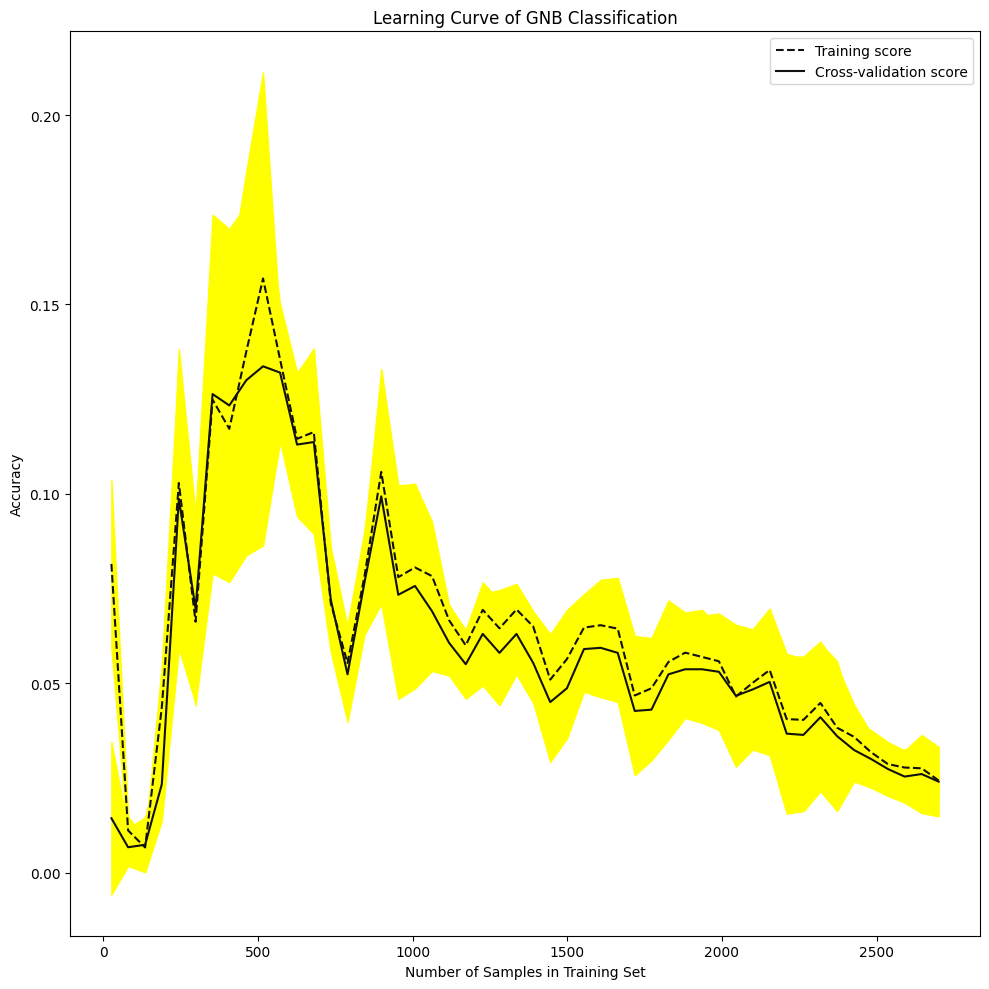

In [57]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="yellow")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="yellow")

plt.title("Learning Curve of GNB Classification")
plt.xlabel("Number of Samples in Training Set"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()